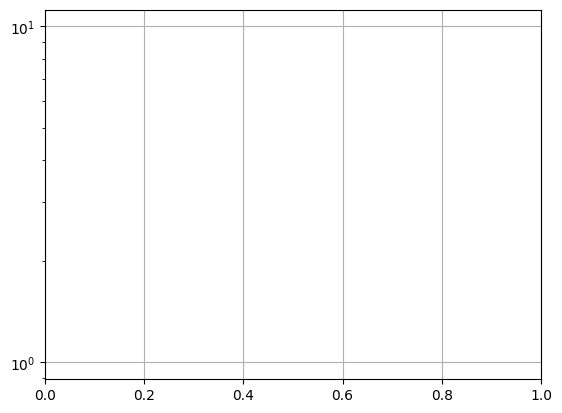

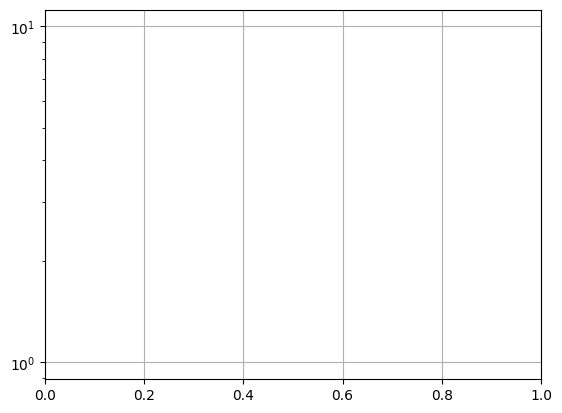

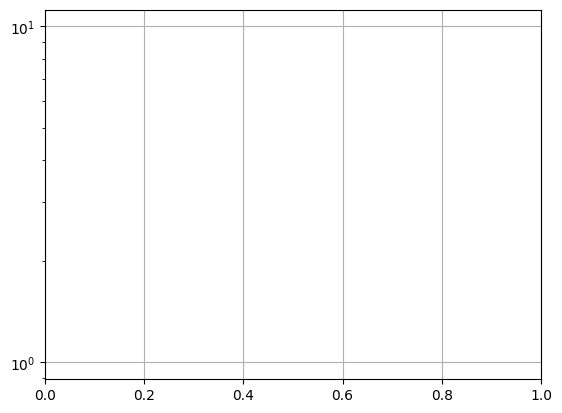

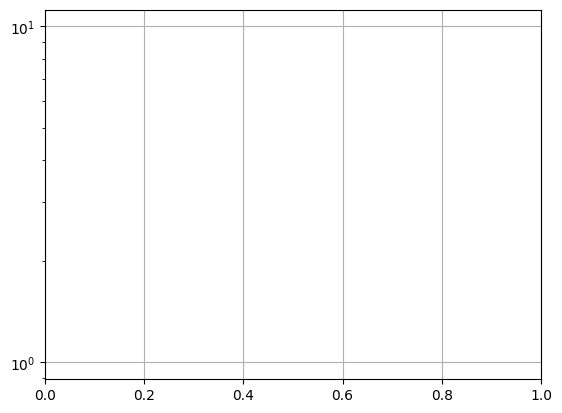

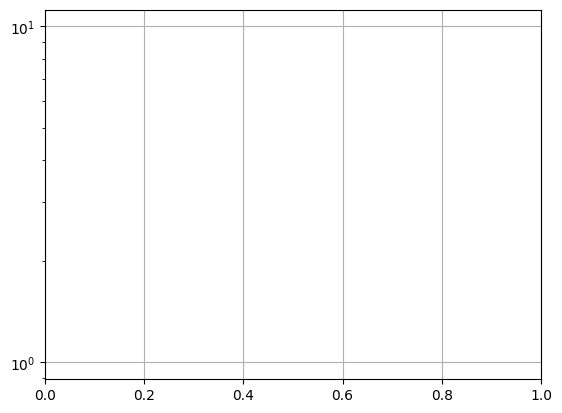

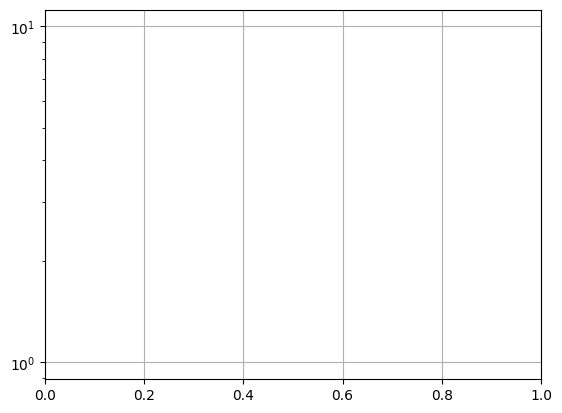

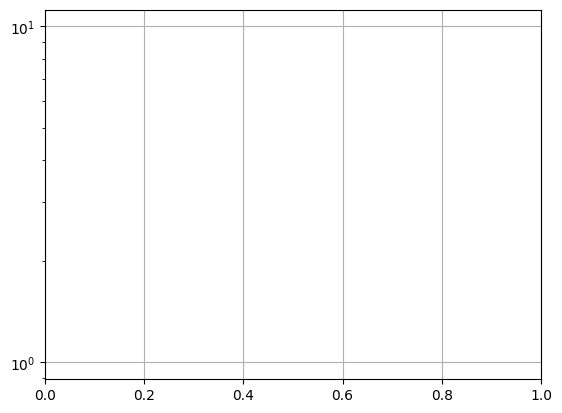

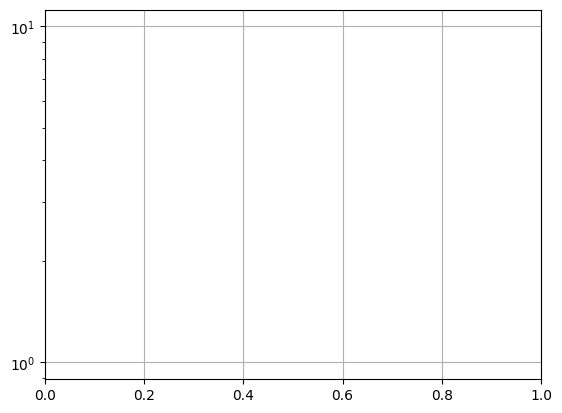

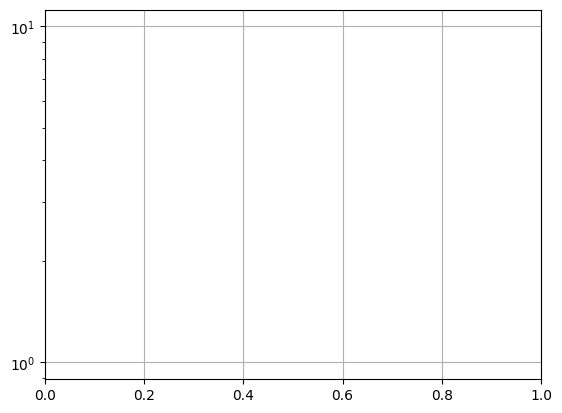

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import random


n = 50

x_0 = np.random.normal(0,1,size=n)
y_0 = np.random.normal(0,1,size=n)

initnorm = np.sqrt(np.linalg.norm(x_0)**2+np.linalg.norm(y_0)**2)

x_0 = x_0/initnorm
y_0 = y_0/initnorm

maxeig=0
mineig=-1

N = 1000
markevery = N/100
fig1 = plt.figure(1)
ax1 = fig1.gca()
ax1.set_yscale('log')
plt.grid()
fig2 = plt.figure(2)
ax2 = fig2.gca()
ax2.set_yscale('log')
plt.grid()
fig3 = plt.figure(3)
ax3 = fig3.gca()
ax3.set_yscale('log')
plt.grid()
fig4 = plt.figure(4)
ax4 = fig4.gca()
ax4.set_yscale('log')
plt.grid()
fig5 = plt.figure(5)
ax5 = fig5.gca()
ax5.set_yscale('log')
plt.grid()
fig6 = plt.figure(6)
ax6 = fig6.gca()
ax6.set_yscale('log')
plt.grid()
fig7 = plt.figure(7)
ax7 = fig7.gca()
ax7.set_yscale('log')
plt.grid()
fig8 = plt.figure(8)
ax8 = fig8.gca()
ax8.set_yscale('log')
plt.grid()
fig9 = plt.figure(9)
ax9 = fig9.gca()
ax9.set_yscale('log')
plt.grid()

randmat = np.random.normal(0, 1, size=(n,n))
randmat = (1/2)*(randmat+np.transpose(randmat))

eigenvalues, eigenvectors = np.linalg.eig(randmat)
eigs = np.diag(np.logspace(maxeig,mineig, num=n))
A1 = np.dot(np.dot(eigenvectors,eigs),np.transpose(eigenvectors))

randmat = np.random.normal(0, 1, size=(n,n))
randmat = (1/2)*(randmat+np.transpose(randmat))

eigenvalues, eigenvectors = np.linalg.eig(randmat)
eigs = np.diag(np.logspace(maxeig,mineig, num=n))
A2 = np.dot(np.dot(eigenvectors,eigs),np.transpose(eigenvectors))

randmat = np.random.normal(0, 1, size=(n,n))
randmat = (1/2)*(randmat+np.transpose(randmat))

eigenvalues, eigenvectors = np.linalg.eig(randmat)
eigs = np.diag(np.logspace(maxeig,mineig, num=n))
B1 = np.dot(np.dot(eigenvectors,eigs),np.transpose(eigenvectors))

randmat = np.random.normal(0, 1, size=(n,n))
randmat = (1/2)*(randmat+np.transpose(randmat))

eigenvalues, eigenvectors = np.linalg.eig(randmat)
eigs = np.diag(np.logspace(maxeig,mineig, num=n))
B2 = np.dot(np.dot(eigenvectors,eigs),np.transpose(eigenvectors))

randmat = np.random.normal(0, 1, size=(n,n))
randmat = (1/2)*(randmat+np.transpose(randmat))

eigenvalues, eigenvectors = np.linalg.eig(randmat)
eigs = np.diag(np.logspace(maxeig,mineig, num=n))
C = np.dot(np.dot(eigenvectors,eigs),np.transpose(eigenvectors))

#V(x,y)
def grad(x, y):
    vx = 4*np.dot(np.transpose(x),np.dot(A2,x))*np.dot(A2,x)*np.dot(A2,x)+4*np.dot(A1,x)+4*np.dot(C,y)
    vy = 4*np.dot(np.transpose(y),np.dot(B2,y))*np.dot(B2,y)*np.dot(B2,y)+4*np.dot(B1,y)-4*np.dot(C,x)
    return vx, vy

mu=0.0
std = 0.5

seed = 0
random.seed(seed)


def gaussian_noise(x,y,mu):
    cov = 0.5*np.identity(2*n)
    mu = mu*np.ones(2*n)
    noise = np.random.multivariate_normal(mu,cov)
    x_noise = noise[0:n]
    y_noise = noise[n:(2*n)]
    gx, gy = grad(x,y)
    return gx+x_noise,gy+y_noise ##same setting as in DSEG paper

def gaussian_noise_scaled(x,y,mu):
    scaling = 10e-2
    dist = np.linalg.norm(x)**2 + np.linalg.norm(y)**2
    std = scaling*dist
    
    cov = std*np.identity(2*n)
    mu = mu*np.ones(2*n)
    noise = np.random.multivariate_normal(mu,cov)
    x_noise = noise[0:n]
    y_noise = noise[n:(2*n)]
    gx, gy = grad(x,y)
    return gx+x_noise,gy+y_noise


##three different noise settings
stochastic_oracle_d = lambda x, y: grad(x,y)
stochastic_oracle_affine = lambda x, y: gaussian_noise(x,y,mu)
stochastic_oracle_decaying =lambda x, y: gaussian_noise_scaled(x,y,mu)

In [52]:
########AdaEG-Norm alg - Algorithm 2
def AdaEG_Norm(N,eta,x_0,y_0,stochastic_oracle):
    x,y = x_0,y_0
    dist_opt_hist = [np.sum(x**2 + y**2)]###record distance to the optimal solution, 0 in this case
    dist_opt_avg_hist= [np.sum(x**2 + y**2)]
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    x_sum = np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    ###compute b_bar square in the alg
    b_bar = 10e-2
    b_bar_hist = [b_bar]
    b = b_bar**2 ###compute b to the fourth in the alg
   # b_hist = [b]
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        stochastic_grad = np.sum(stochastic_grad_x**2 + stochastic_grad_y**2)
        b = b + stochastic_grad
        alpha = eta[0]/np.power(b,1/4)
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
        ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
        ###update stepsize for intrapolation step
        stochastic_grad_bar = np.sum(stochastic_grad_x_bar**2 + stochastic_grad_y_bar**2)
        b_bar = b_bar +stochastic_grad_bar + stochastic_grad
        b_bar_hist.append(b_bar)
        gamma = eta[1]/np.power(b_bar,1/2)
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
        ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x**2 + y**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2 + y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist
###Initialize the paramters
eta = [1,1]

In [53]:
####Run 20 loops and get the mean value
N_loop = 20
grad_norm_avg_hist_affine_dict = dict()
grad_norm_avg_hist_decaying_dict = dict()
dist_opt_avg_hist_affine_dict= dict()
dist_opt_hist_affine_dict= dict()
dist_opt_avg_hist_decaying_dict= dict()
dist_opt_hist_decaying_dict= dict()
for i in range(N_loop):
    grad_norm_avg_hist_affine_dict[i],dist_opt_avg_hist_affine_dict[i],dist_opt_hist_affine_dict[i] = AdaEG_Norm(N,eta,x_0,y_0,stochastic_oracle_affine)
    grad_norm_avg_hist_decaying_dict[i],dist_opt_avg_hist_decaying_dict[i],dist_opt_hist_decaying_dict[i] = AdaEG_Norm(N,eta,x_0,y_0,stochastic_oracle_decaying)
import pandas as pd
pd1 = pd.DataFrame(grad_norm_avg_hist_affine_dict)
grad_norm_avg_hist_affine = np.sum(pd1,axis = 1)/N_loop
pd2 = pd.DataFrame(dist_opt_avg_hist_affine_dict)
dist_opt_avg_hist_affine = np.sum(pd2,axis=1)/N_loop
pd3 = pd.DataFrame(dist_opt_hist_affine_dict)
dist_opt_hist_affine= np.sum(pd3, axis = 1)/N_loop

pd4 = pd.DataFrame(grad_norm_avg_hist_decaying_dict)
grad_norm_avg_hist_decaying = np.sum(pd4,axis = 1)/N_loop
pd5 = pd.DataFrame(dist_opt_avg_hist_decaying_dict)
dist_opt_avg_hist_decaying = np.sum(pd5,axis=1)/N_loop
pd6 = pd.DataFrame(dist_opt_hist_decaying_dict)
dist_opt_hist_decaying= np.sum(pd6, axis = 1)/N_loop

In [54]:
ax2.plot(dist_opt_hist_affine,markevery=markevery, marker = '.',label='AdaEG-S')
ax3.plot(dist_opt_hist_decaying,markevery=markevery, marker = '.',label='AdaEG-S')
ax5.plot(grad_norm_avg_hist_affine,markevery=markevery, marker = '.',label='AdaEG-S')
ax6.plot(grad_norm_avg_hist_decaying,markevery=markevery, marker = '.',label='AdaEG-S')
ax8.plot(dist_opt_avg_hist_affine,markevery=markevery, marker = '.',label='AdaEG-S')
ax9.plot(dist_opt_avg_hist_decaying,markevery=markevery, marker = '.',label='AdaEG-S')

In [55]:
######Two time scale_decaying stepsize
def DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle):
    
    x,y = x_0,y_0
    longer_stepsize = l_step
    shorter_stepsize = s_step
    dist_opt_hist = [np.sum(x**2 + y**2)] ###record distance to the optimal solution, 0 in this case
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    dist_opt_avg_hist= [np.sum(x**2 + y**2)]
    x_sum = np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        alpha = longer_stepsize/(np.power(i+denom,0.1))
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
#       ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
#       ###update stepsize for intrapolation step
        gamma = shorter_stepsize/(np.power(i+denom,0.9))
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
#         x_avg=np.sum(x_hist)/len(x_hist)
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
        ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x**2 + y**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2+y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist

###Initialize the paramters
#Original parameters were lstep = 1, sstep = 0.1, which performs worse
denom = 19
l_step = 0.25
s_step = 0.15

In [56]:
####Run 20 loops and get the mean value
N_loop = 20
grad_norm_avg_hist_affine_dict = dict()
grad_norm_avg_hist_decaying_dict = dict()
dist_opt_avg_hist_affine_dict= dict()
dist_opt_hist_affine_dict= dict()
dist_opt_avg_hist_decaying_dict= dict()
dist_opt_hist_decaying_dict= dict()
for i in range(N_loop):
    grad_norm_avg_hist_affine_dict[i],dist_opt_avg_hist_affine_dict[i],dist_opt_hist_affine_dict[i] = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
    grad_norm_avg_hist_decaying_dict[i],dist_opt_avg_hist_decaying_dict[i],dist_opt_hist_decaying_dict[i] = DSEG(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
import pandas as pd
pd1 = pd.DataFrame(grad_norm_avg_hist_affine_dict)
grad_norm_avg_hist_affine = np.sum(pd1,axis = 1)/N_loop
pd2 = pd.DataFrame(dist_opt_avg_hist_affine_dict)
dist_opt_avg_hist_affine = np.sum(pd2,axis=1)/N_loop
pd3 = pd.DataFrame(dist_opt_hist_affine_dict)
dist_opt_hist_affine= np.sum(pd3, axis = 1)/N_loop

pd4 = pd.DataFrame(grad_norm_avg_hist_decaying_dict)
grad_norm_avg_hist_decaying = np.sum(pd4,axis = 1)/N_loop
pd5 = pd.DataFrame(dist_opt_avg_hist_decaying_dict)
dist_opt_avg_hist_decaying = np.sum(pd5,axis=1)/N_loop
pd6 = pd.DataFrame(dist_opt_hist_decaying_dict)
dist_opt_hist_decaying= np.sum(pd6, axis = 1)/N_loop

In [57]:
ax2.plot(dist_opt_hist_affine,markevery=markevery, marker = '.',label='DSEG')
ax3.plot(dist_opt_hist_decaying,markevery=markevery, marker = '.',label='DSEG')
ax5.plot(grad_norm_avg_hist_affine,markevery=markevery, marker = '.',label='DSEG')
ax6.plot(grad_norm_avg_hist_decaying,markevery=markevery, marker = '.',label='DSEG')
ax8.plot(dist_opt_avg_hist_affine,markevery=markevery, marker = '.',label='DSEG')
ax9.plot(dist_opt_avg_hist_decaying,markevery=markevery, marker = '.',label='DSEG')

In [58]:
######Two time scale stepsize - fixed (EG+)
def DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle):
    
    x,y = x_0,y_0
    longer_stepsize = l_step
    shorter_stepsize = s_step
    dist_opt_hist = [np.sum(x**2 + y**2)] ###record distance to the optimal solution, 0 in this case
    grad_x,grad_y = grad(x,y) 
    grad_norm = np.sum(grad_x**2 + grad_y**2)
    grad_norm_hist = [grad_norm]
    grad_norm_avg_hist = [grad_norm]
    dist_opt_avg_hist=[np.sum(x**2 + y**2)]
    x_sum=np.array(x_0)
    y_sum = np.array(y_0)
    stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
    N_iters = N
    for i in range(N_iters):
        ###update stepsize for extrapolation step 
        alpha = longer_stepsize/(np.power(denom,0.1))
        ###update middle points
        x_bar = x - alpha*stochastic_grad_x 
        y_bar = y - alpha*stochastic_grad_y
#       ###compute stochastic oracle at middle points
        stochastic_grad_x_bar,stochastic_grad_y_bar = stochastic_oracle(x_bar,y_bar)
#       ###update stepsize for intrapolation step
        gamma = shorter_stepsize/(np.power(denom,0.9))
        ###update x,y
        x = x - gamma*stochastic_grad_x_bar
        y = y - gamma*stochastic_grad_y_bar
        ###update stochastic oracle at x,y
        stochastic_grad_x,stochastic_grad_y = stochastic_oracle(x,y)
        #####record x,y
        x_sum = x_sum +np.array(x)
        y_sum = y_sum +np.array(y)
        #####record averaged iterates
        x_avg = x_sum / (i+1)
        y_avg= y_sum /(i+1)
        ###record grad_norm at updated x,y
        grad_x,grad_y = grad(x,y) 
        grad_norm = np.sum(grad_x**2 + grad_y**2) 
        grad_norm_hist.append(grad_norm)
#         ###record grad_norm_avg 
        grad_norm_avg_hist.append(np.sum(grad_norm_hist)/len(grad_norm_hist))
        ###record the distance to the optimal solution
        dist_opt_hist.append(np.sum(x**2 + y**2))
        dist_opt_avg_hist.append(np.sum(x_avg**2+y_avg**2))
    return grad_norm_avg_hist,dist_opt_avg_hist,dist_opt_hist

###Initialize the paramters
denom = 19
l_step = 0.2
s_step = 0.05

In [59]:
####Run 20 loops and get the mean value
N_loop = 20
grad_norm_avg_hist_affine_dict = dict()
grad_norm_avg_hist_decaying_dict = dict()
dist_opt_avg_hist_affine_dict= dict()
dist_opt_hist_affine_dict= dict()
dist_opt_avg_hist_decaying_dict= dict()
dist_opt_hist_decaying_dict= dict()
for i in range(N_loop):
    grad_norm_avg_hist_affine_dict[i],dist_opt_avg_hist_affine_dict[i],dist_opt_hist_affine_dict[i] = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_affine)
    grad_norm_avg_hist_decaying_dict[i],dist_opt_avg_hist_decaying_dict[i],dist_opt_hist_decaying_dict[i] = DSEG_fixed(N,l_step,s_step,denom,x_0,y_0,stochastic_oracle_decaying)
import pandas as pd
pd1 = pd.DataFrame(grad_norm_avg_hist_affine_dict)
grad_norm_avg_hist_affine = np.sum(pd1,axis = 1)/N_loop
pd2 = pd.DataFrame(dist_opt_avg_hist_affine_dict)
dist_opt_avg_hist_affine = np.sum(pd2,axis=1)/N_loop
pd3 = pd.DataFrame(dist_opt_hist_affine_dict)
dist_opt_hist_affine= np.sum(pd3, axis = 1)/N_loop

pd4 = pd.DataFrame(grad_norm_avg_hist_decaying_dict)
grad_norm_avg_hist_decaying = np.sum(pd4,axis = 1)/N_loop
pd5 = pd.DataFrame(dist_opt_avg_hist_decaying_dict)
dist_opt_avg_hist_decaying = np.sum(pd5,axis=1)/N_loop
pd6 = pd.DataFrame(dist_opt_hist_decaying_dict)
dist_opt_hist_decaying= np.sum(pd6, axis = 1)/N_loop

In [60]:
ax2.plot(dist_opt_hist_affine,markevery=markevery, marker = '.',label='EG+')
ax3.plot(dist_opt_hist_decaying,markevery=markevery, marker = '.',label='EG+')
ax5.plot(grad_norm_avg_hist_affine,markevery=markevery, marker = '.',label='EG+')
ax6.plot(grad_norm_avg_hist_decaying,markevery=markevery, marker = '.',label='EG+')
ax8.plot(dist_opt_avg_hist_affine,markevery=markevery, marker = '.',label='EG+')
ax9.plot(dist_opt_avg_hist_decaying,markevery=markevery, marker = '.',label='EG+')

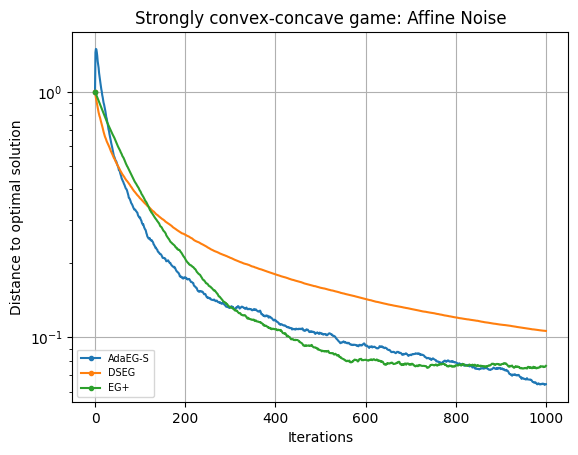

In [73]:
####under affine noise
ax2.set_title("Strongly convex-concave game: Affine Noise")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Distance to optimal solution")
ax2.legend(loc=3,fontsize = 'x-small')
fig2
#fig2.savefig("Strongly convex-concave game_affine_noise_distance_to_opt")

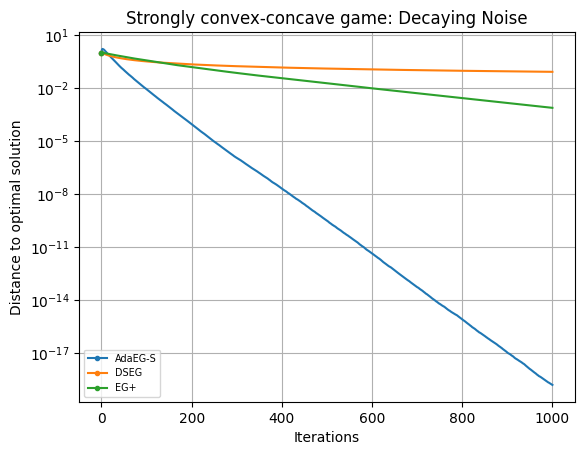

In [74]:
####under scaled noise
ax3.set_title("Strongly convex-concave game: Decaying Noise")
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Distance to optimal solution")
ax3.legend(loc=3, fontsize = 'x-small')
fig3
#fig3.savefig("Strongly convex-concave game_scaled_noise_distance_to_opt")

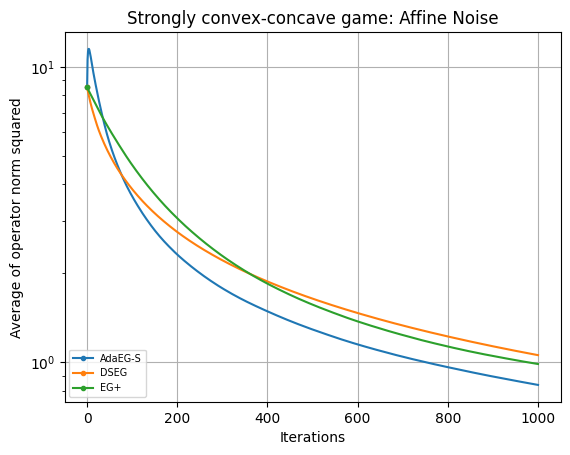

In [75]:
####under affine noise
ax5.set_title("Strongly convex-concave game: Affine Noise")
ax5.set_xlabel("Iterations")
ax5.set_ylabel("Average of operator norm squared")
ax5.legend(loc=3,fontsize = 'x-small')
fig5
#fig5.savefig("Strongly convex-concave game_affine_noise_averaged_norm_square")

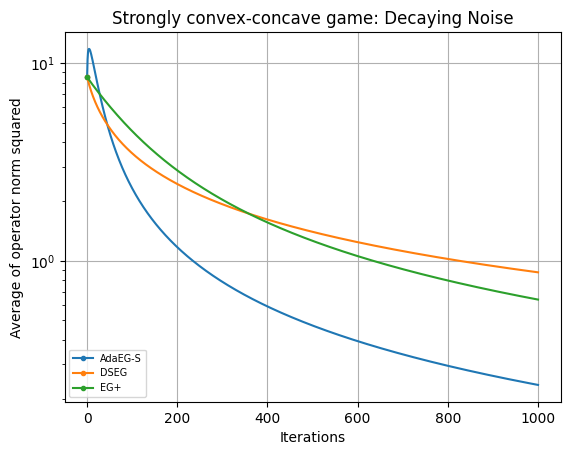

In [76]:
####under scaled noise
ax6.set_title("Strongly convex-concave game: Decaying Noise")
ax6.set_xlabel("Iterations")
ax6.set_ylabel("Average of operator norm squared")
ax6.legend(loc=3, fontsize = 'x-small')
fig6
#fig6.savefig("Strongly convex-concave game_scaled_noise_averaged_norm_square")

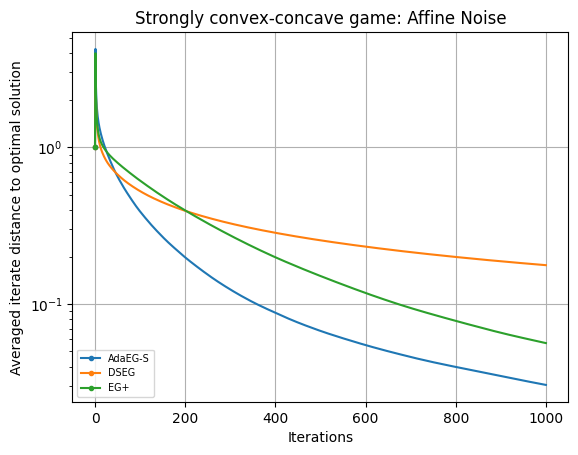

In [77]:
####under affine noise
ax8.set_title("Strongly convex-concave game: Affine Noise")
ax8.set_xlabel("Iterations")
ax8.set_ylabel("Averaged iterate distance to optimal solution")
ax8.legend(loc=3,fontsize = 'x-small')
fig8
#fig8.savefig("Strongly convex-concave game_affine_noise_averaged_distance_to_opt")

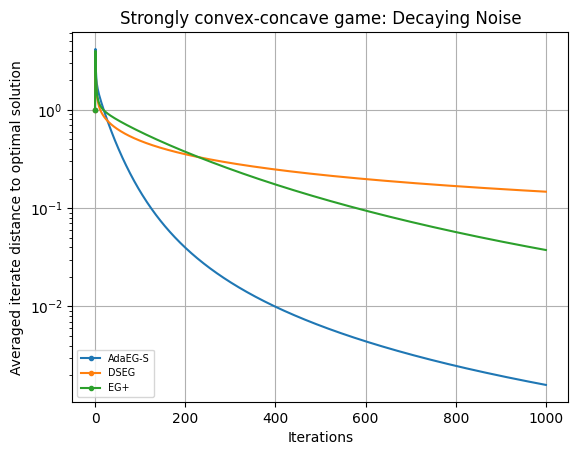

In [78]:
####under scaled noise
ax9.set_title("Strongly convex-concave game: Decaying Noise")
ax9.set_xlabel("Iterations")
ax9.set_ylabel("Averaged iterate distance to optimal solution")
ax9.legend(loc=3, fontsize = 'x-small')
fig9
#fig9.savefig("Strongly convex-concave game_scaled_noise_averaged_distance_to_opt")